Grand comparison of different noise levels, sample sizes and distance metrics

In [1]:

from typing import List
import mhn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.spatial
import scipy.cluster
import RandomMHNGenerator as rmg
import ClusterableMhnGenerator as cmg
import EventDistanceMeasurer as edm
import mhn_tools

c:\Users\michi\Desktop\Uni\Bachelorarbeit\ws24_mbonart_mhn-feature-clustering\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading from mbonart_checkpoints/rmg1/mhn_SET
loading from mbonart_checkpoints/rmg1/mhn_TRAINED


(<matplotlib.image.AxesImage at 0x26d1e9a1190>,
 <matplotlib.colorbar.Colorbar at 0x26d1ebb3710>)

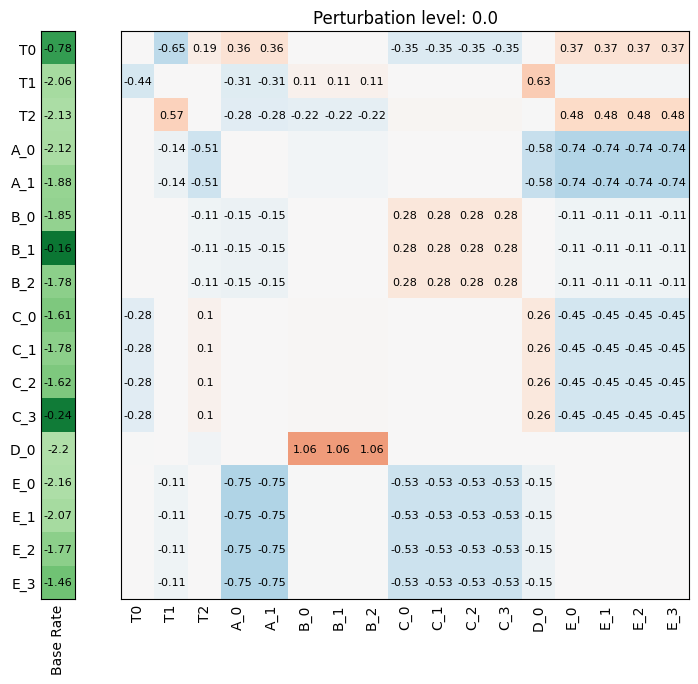

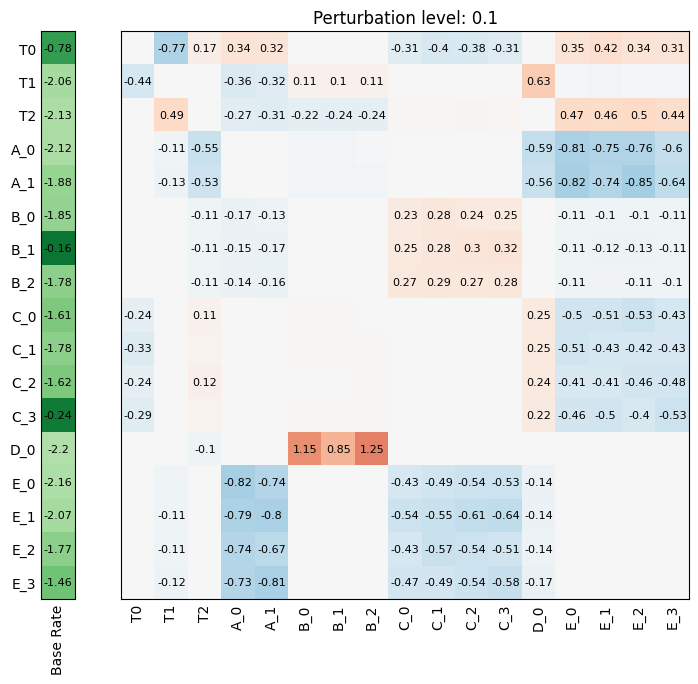

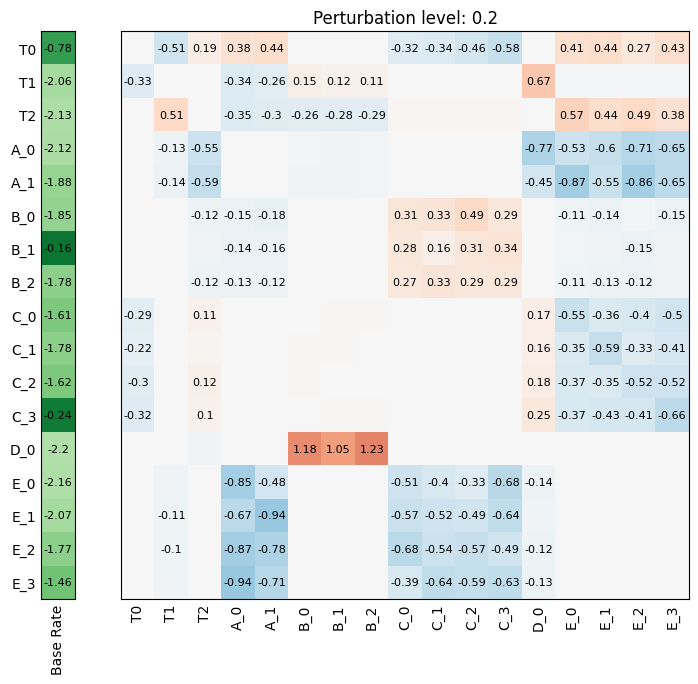

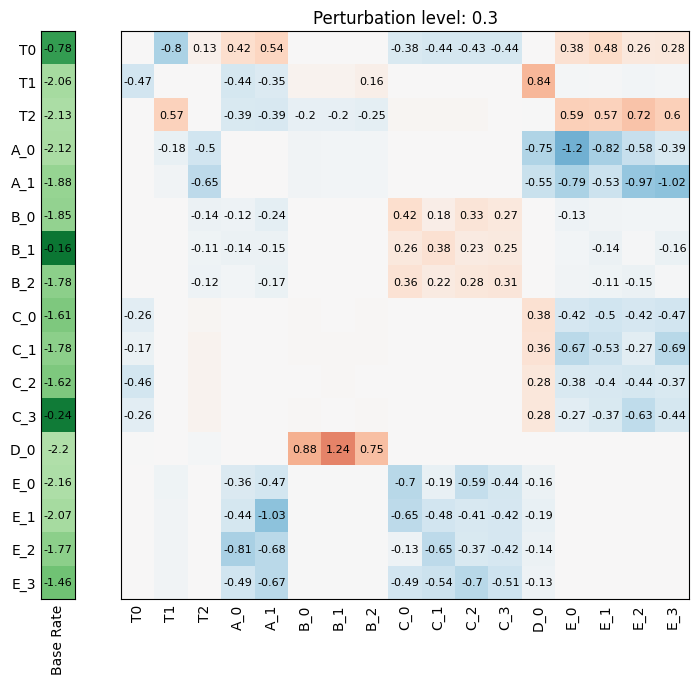

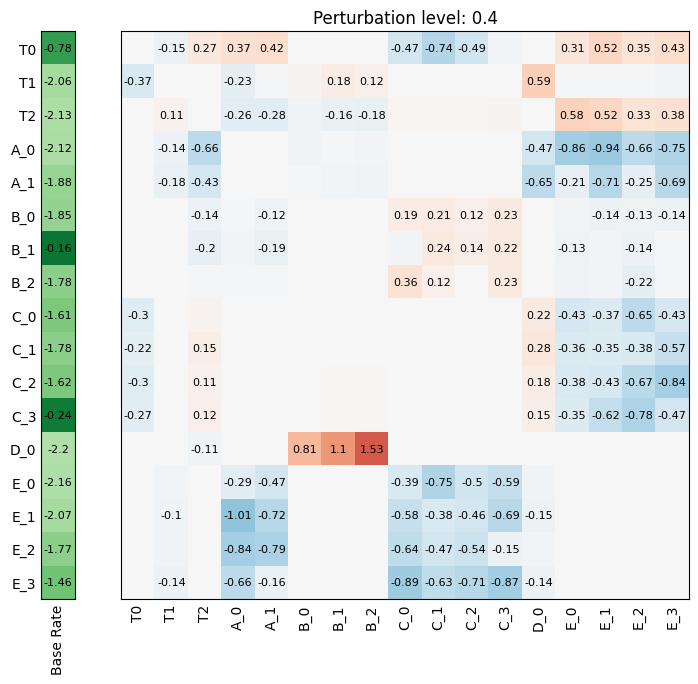

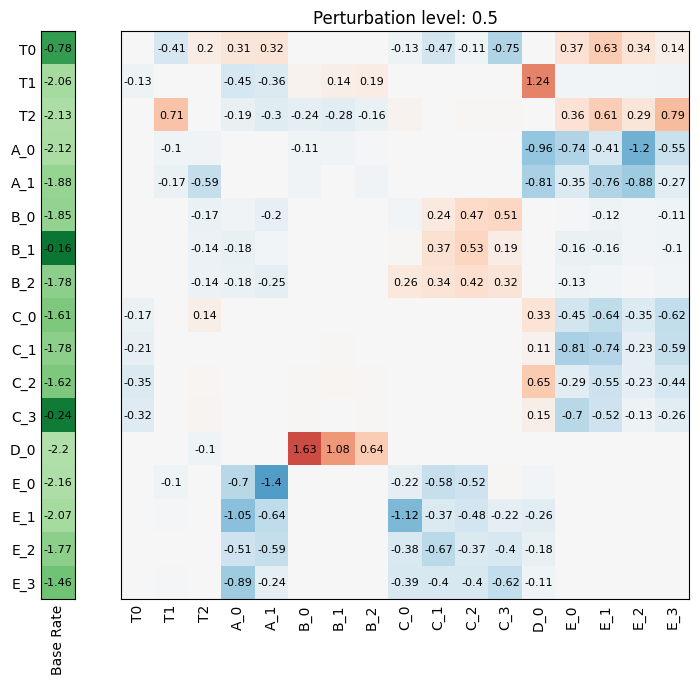

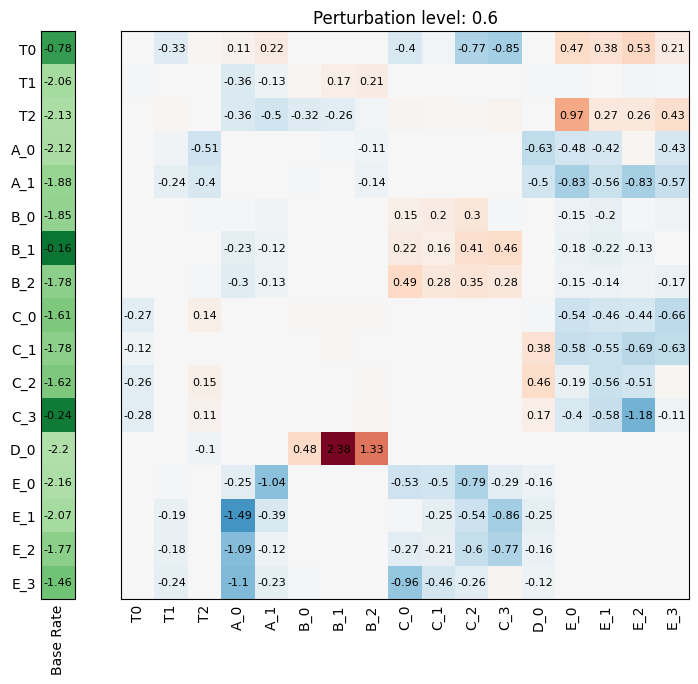

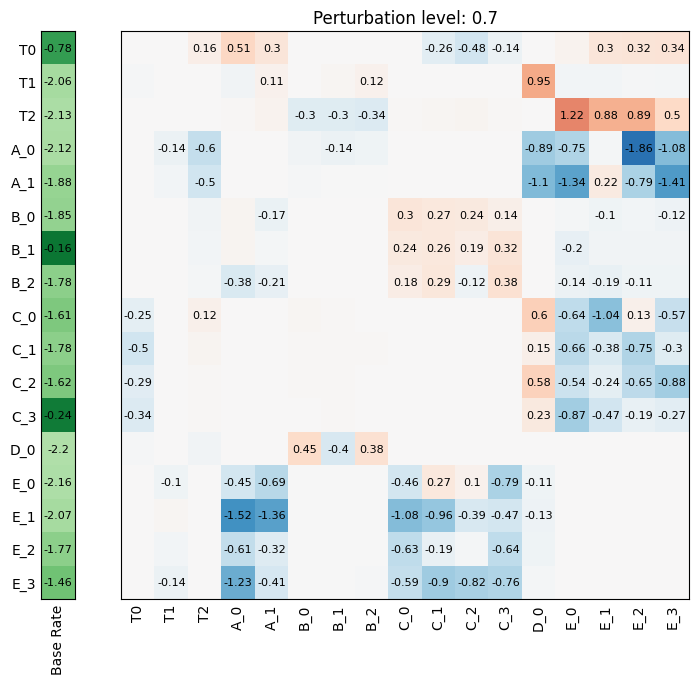

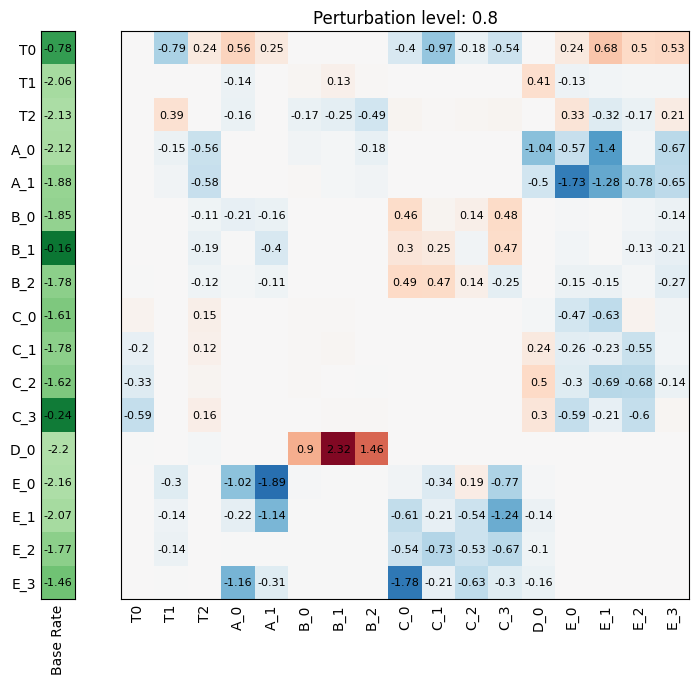

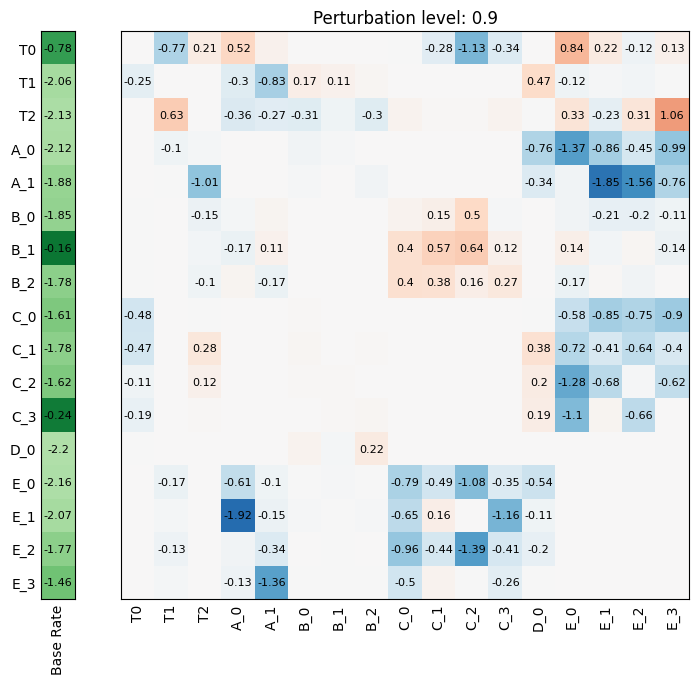

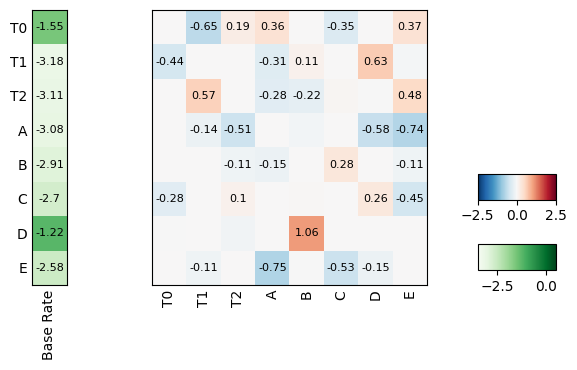

In [31]:
np.random.seed(12345)

cl_generator = cmg.ClusterableMhnGenerator(3,5)
rand_generator = rmg.RandomMHNGenerator(cl_generator.getEvents())
rand_generator.loadfrom("mbonart_checkpoints/rmg1")
cl_generator.setClusterMHN(rand_generator.getMHN())
given_clustersizes=[2,3,4,1,4]
cl_generator.splitClusters(given_clustersizes)
cl_generator.randomizeBaseRates() 

test_events = cl_generator.getEvents(cmg.DOM.TEST)
events = cl_generator.getEvents(cmg.DOM.CLUSTER)


noise_levels=[i/10 for i in range(10)]
sample_sizes=[1000, 2500, 7500, 20000, 50000, 100000]

np.random.seed(31415)
np.random.seed(3)   #TODO: implement seeded experiment system
noisy_mhns: List[mhn.model.cMHN] = [cl_generator.get_noisy_MHN(amplitude= noise_level) for noise_level in noise_levels]

sampled_datas :List[List[pd.DataFrame]]=[]
sampled_datas=[[noisy_mhn.sample_artificial_data(sample_size, as_dataframe=True) for sample_size in sample_sizes] for noisy_mhn in noisy_mhns]
    

for nl, noisy_mhn in zip(noise_levels,noisy_mhns):
    noisy_mhn.plot(colorbar=False)
    plt.title(f"Perturbation level: {nl}")

rand_generator.getMHN().plot()

Train all EventDistanceMeasurers

In [32]:
all_dist_measurers:List[List[edm.EventDistanceMeasurer]] = [[edm.getDistMeasurer(sampled_data, cut_first_col=False) for sampled_data in row] for row in sampled_datas]


0x1.b4b5bda067d01p+63
Directory for storage is edm_b4b5bda067d01/T0_T1_T2
check if mbonart_checkpoints/edm_b4b5bda067d01/T0_T1_T2   does exist
0x1.e0458bb7fce7bp+58
Directory for storage is edm_e0458bb7fce7b/T0_T1_T2
check if mbonart_checkpoints/edm_e0458bb7fce7b/T0_T1_T2   does exist
0x1.099bf5c73524dp+63
Directory for storage is edm_099bf5c73524d/T0_T1_T2
check if mbonart_checkpoints/edm_099bf5c73524d/T0_T1_T2   does exist
0x1.bd6adfa2da716p+61
Directory for storage is edm_bd6adfa2da716/T0_T1_T2
check if mbonart_checkpoints/edm_bd6adfa2da716/T0_T1_T2   does exist
0x1.5e56ec3cb6cabp+63
Directory for storage is edm_5e56ec3cb6cab/T0_T1_T2
check if mbonart_checkpoints/edm_5e56ec3cb6cab/T0_T1_T2   does exist
0x1.ba60307961a93p+63
Directory for storage is edm_ba60307961a93/T0_T1_T2
check if mbonart_checkpoints/edm_ba60307961a93/T0_T1_T2   does exist
0x1.a1601bdbff439p+61
Directory for storage is edm_a1601bdbff439/T0_T1_T2
check if mbonart_checkpoints/edm_a1601bdbff439/T0_T1_T2   does exist

In [33]:
for row in all_dist_measurers:
    for dist_measurer in row:
        dist_measurer.compute_distance_matrix(edm.DIST.OFFDIAG_L1_SYM)

In [40]:
cluster_size_range=[5]#[4,5,6]
#cluster_size_range=range(14)
all_linkages=[[scipy.cluster.hierarchy.linkage(dist_measurer._dist_mat, method="average") for dist_measurer in row] for row in all_dist_measurers]
all_cut_trees=[[[np.concatenate(scipy.cluster.hierarchy.cut_tree(linkage, n_clusters=n_clusters)) for n_clusters in cluster_size_range] for linkage in row] for row in all_linkages]

C:\Users\michi\AppData\Local\Temp\ipykernel_40664\2098489149.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  all_linkages=[[scipy.cluster.hierarchy.linkage(dist_measurer._dist_mat, method="average") for dist_measurer in row] for row in all_dist_measurers]


In [41]:
from sklearn.metrics.cluster import adjusted_rand_score

cluster_solution=np.concatenate([[i]*c_size for i, c_size in enumerate(given_clustersizes)])

all_ar_scores=[[[adjusted_rand_score(cluster_solution,cut_tree) for cut_tree in l] for l in row] for row in all_cut_trees]
all_mean_ar_scores=[[np.mean(l) for l in row] for row in all_ar_scores]
all_max_ar_scores=[[np.max(l) for l in row] for row in all_ar_scores]
all_sum_ar_scores=[[np.sum(l) for l in row] for row in all_ar_scores]

Text(50.722222222222214, 0.5, 'Perturbation level')

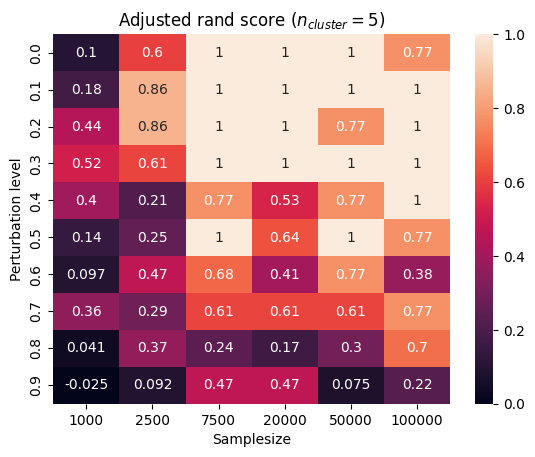

In [42]:
sns.heatmap(all_mean_ar_scores,vmin=0,vmax=1, xticklabels=sample_sizes, yticklabels=noise_levels, annot=True)
#plt.title("MEAN of Adjusted rand scores  $(n_{cluster} \in \{4,5,6\})$")
#plt.title("Adjusted rand score (non-symmetrized L1) $(n_{cluster} =5)$")
plt.title("Adjusted rand score $(n_{cluster} =5)$")
plt.xlabel("Samplesize")
plt.ylabel("Perturbation level")

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
C:\Users\michi\AppData\Local\Temp\ipykernel_40664\2356091297.py:2: SyntaxWarning: invalid escape sequence '\i'
  plt.title("MAX of Adjusted rand scores $(n_{cluster} \in \{4,5,6\})$")


Text(50.722222222222214, 0.5, 'Perturbation level')

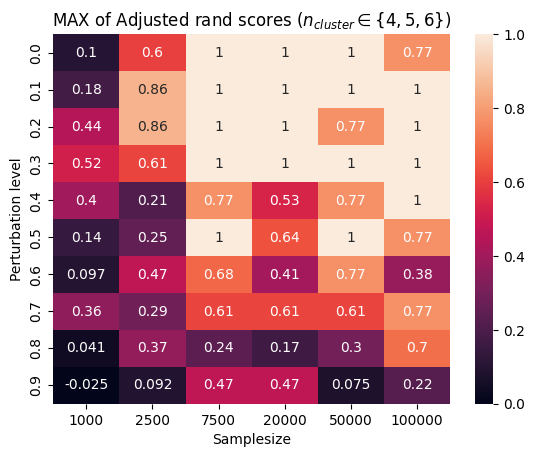

In [43]:
sns.heatmap(all_max_ar_scores,vmin=0,vmax=1, xticklabels=sample_sizes, yticklabels=noise_levels, annot=True)
plt.title("MAX of Adjusted rand scores $(n_{cluster} \in \{4,5,6\})$")
plt.xlabel("Samplesize")
plt.ylabel("Perturbation level")

<>:2: SyntaxWarning: invalid escape sequence '\i'
<>:2: SyntaxWarning: invalid escape sequence '\i'
C:\Users\michi\AppData\Local\Temp\ipykernel_40664\2535083948.py:2: SyntaxWarning: invalid escape sequence '\i'
  plt.title("SUM of Adjusted rand scores $(n_{cluster} \in \mathbb{N})$")


Text(50.722222222222214, 0.5, 'Perturbation level')

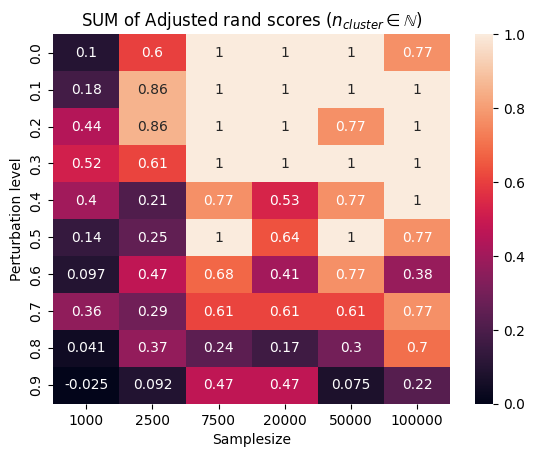

In [44]:
sns.heatmap(all_sum_ar_scores,vmin=0, xticklabels=sample_sizes, yticklabels=noise_levels, annot=True)
plt.title("SUM of Adjusted rand scores $(n_{cluster} \in \mathbb{N})$")
plt.xlabel("Samplesize")
plt.ylabel("Perturbation level")

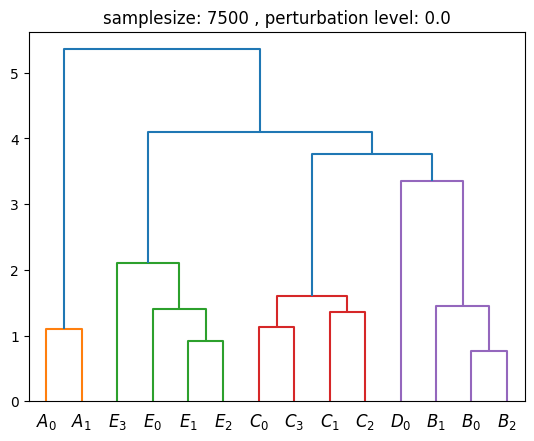

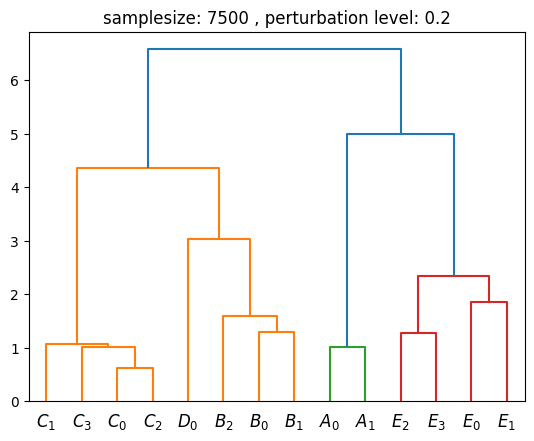

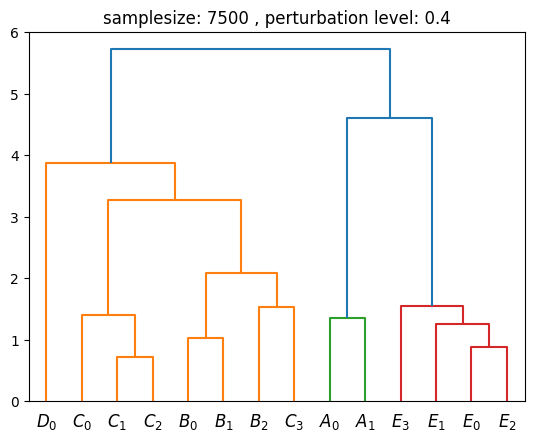

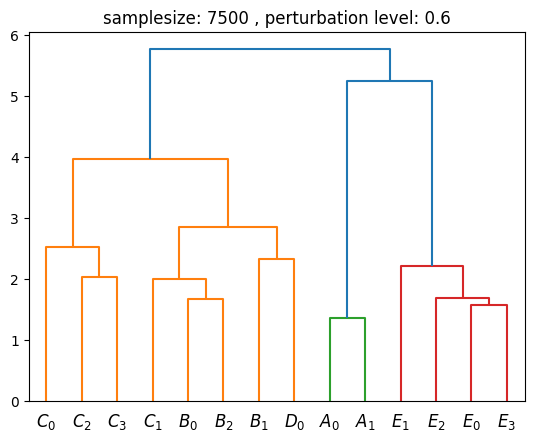

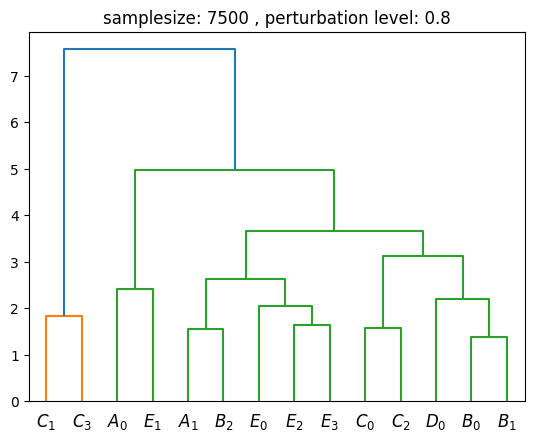

In [45]:
#select and view hierarchical clustering for one example
for nindex in [1,3,5,7,9]:
    ex_linkage=all_linkages[nindex-1][2]
    scipy.cluster.hierarchy.dendrogram(ex_linkage, labels= [f"${ev}$" for ev in events])
    plt.title(f"samplesize: {sample_sizes[2]} , perturbation level: {noise_levels[nindex-1]}")
    plt.show()